<a href="https://colab.research.google.com/github/hhhgggaaa/NYU-Data-Bootcamp-Final-Project/blob/main/Yutong_Zhao_Data_Bootcamp_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install and import required library
!pip install fredapi
from fredapi import Fred
!pip install sktime pmdarima statsmodels matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.compose import EnsembleForecaster
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sktime.forecasting.base import ForecastingHorizon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 6.0 MB/s eta 0:00:00


In [ ]:
### --- Data Collection --- ###

# Connect to FRED API
fred = Fred(api_key="027ebcbd569f20d0871f8abdc6f4ed69")

# Fetch target variable: Producer Price Index for fuel oil
ppi = fred.get_series("APU000072511").rename("fuel-oil")

# Fetch multiple macroeconomic exogenous indicators
exog_dict = {
    "unemployment": "UNRATE",
    "cpi": "CPIAUCSL",
    "Crude Oil (WTI) Price": 'DCOILWTICO',
    "Industrial Production Index": 'INDPRO'}

# Store all exogenous variables into one DataFrame
exog = pd.concat([fred.get_series(v).rename(k) for k, v in exog_dict.items()], axis=1)

# Combine target with exogenous features
df = pd.concat([ppi, exog], axis=1)

# Convert to datetime index with monthly frequency
df.index = pd.to_datetime(df.index)
df.index = df.index.to_period(freq='M')

# Keep data after 1987
df = df[df.index >= '1987-01-01']

# Linearly interpolate missing values in exogenous features
df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method='linear').ffill().bfill()

# Drop missing values
df = df.dropna(subset=['fuel-oil'])

df.info()


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 465 entries, 1987-01 to 2025-09
Freq: M
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fuel-oil                     465 non-null    float64
 1   unemployment                 465 non-null    float64
 2   cpi                          465 non-null    float64
 3   Crude Oil (WTI) Price        465 non-null    float64
 4   Industrial Production Index  465 non-null    float64
dtypes: float64(5)
memory usage: 21.8 KB


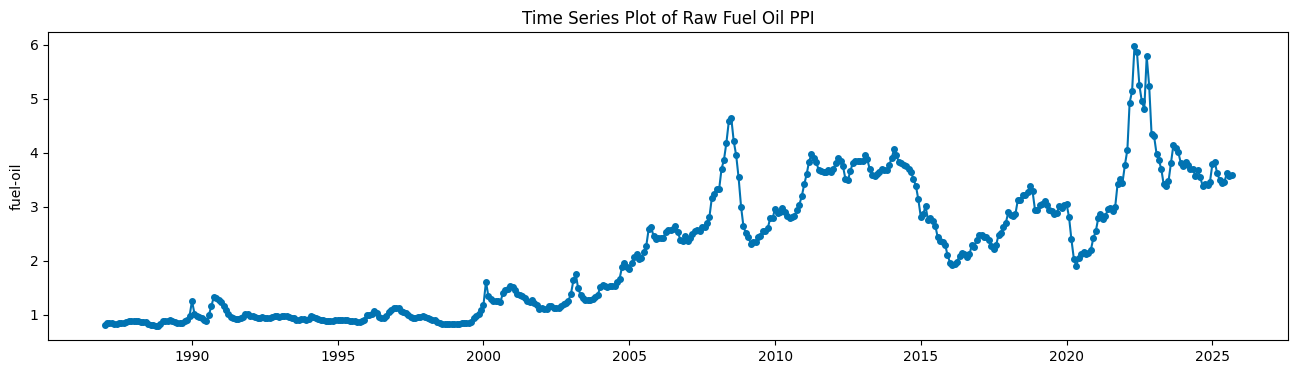

In [ ]:
### --- Exploratory Analysis --- ###

# Plot raw PPI series
plot_series(df['fuel-oil']);
plt.title("Time Series Plot of Raw Fuel Oil PPI")
plt.show()

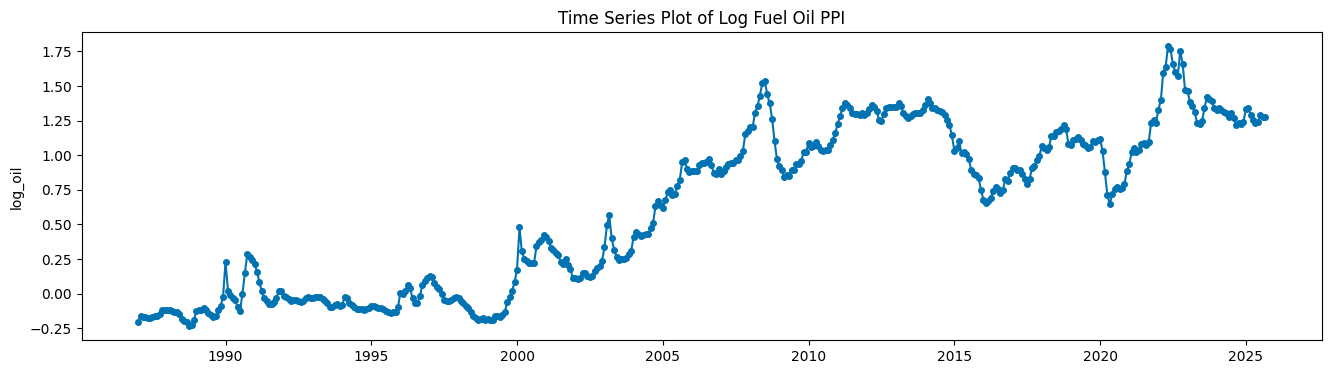

In [ ]:
# Log-transform stabilizes long-run variance
df['log_oil'] = np.log(df['fuel-oil'])
plot_series(df['log_oil']);
plt.title("Time Series Plot of Log Fuel Oil PPI")
plt.show()

<Figure size 1000x400 with 0 Axes>

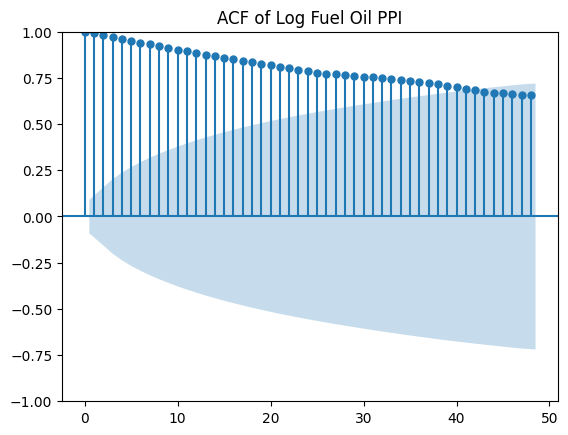

Original Series Stationarity Test:
ADF Statistic: -1.4299, p-value: 0.5679


In [ ]:
### --- Stationarity Check --- ###

y = df['log_oil']
# Autocorrelation plot (ACF)
plt.figure(figsize=(10,4))
plot_acf(y, lags=48)
plt.title("ACF of Log Fuel Oil PPI")
plt.show()

# Augmented Dickey-Fuller test (ADF)
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")

print("Original Series Stationarity Test:")
adf_test(y)

<Figure size 1000x400 with 0 Axes>

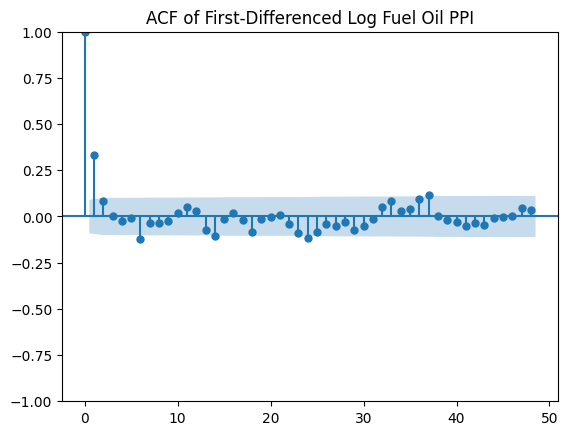

Differenced Series Stationarity Tests:
ADF Statistic: -15.2333, p-value: 0.0000


In [ ]:
# Take first difference
y_diff = y.diff().dropna()

# Stationarity test again with ACF and ADF
plt.figure(figsize=(10,4))
plot_acf(y_diff, lags=48)
plt.title("ACF of First-Differenced Log Fuel Oil PPI")
plt.show()
print("Differenced Series Stationarity Tests:")
adf_test(y_diff)

Correlation with PPI:
unemployment                   0.003260
cpi                            0.885557
Crude Oil (WTI) Price          0.938668
Industrial Production Index    0.826716
dtype: float64
Selected Exogenous Features: ['cpi', 'Crude Oil (WTI) Price', 'Industrial Production Index']


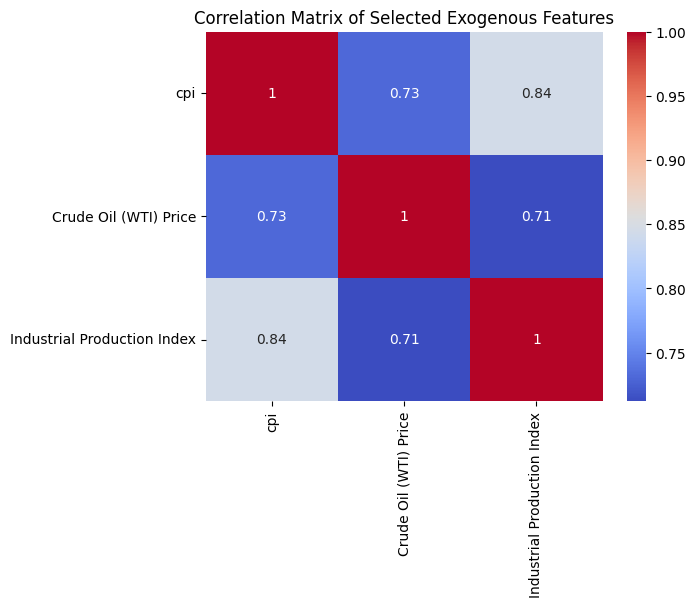

In [ ]:
# Correlation with exogenous features
exog_features = list(exog_dict.keys())
df_exog = df[exog_features]

# Compute correlation with target series
corr_matrix = df_exog.corrwith(y)
print("Correlation with PPI:")
print(corr_matrix)

# Keep only strongly correlated features
selected_exog = corr_matrix[abs(corr_matrix) > 0.4].index.tolist()
print("Selected Exogenous Features:", selected_exog)

# Plot heatmap
sns.heatmap(df_exog[selected_exog].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Selected Exogenous Features")
plt.show()

# Final exogenous dataset
X = df[selected_exog]

In [ ]:
# Train test split
y_train, y_test = temporal_train_test_split(y, test_size=36)
X_train, X_test = X.loc[y_train.index], X.loc[y_test.index]

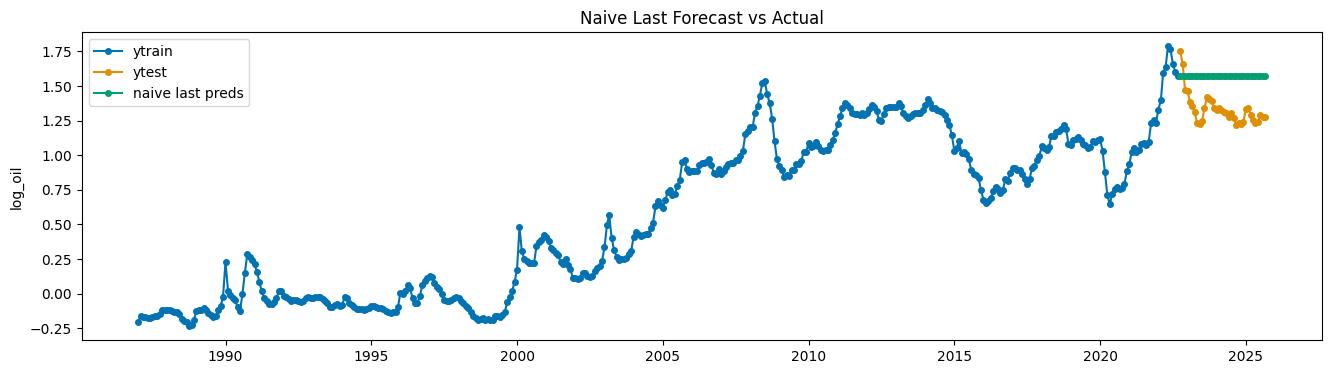

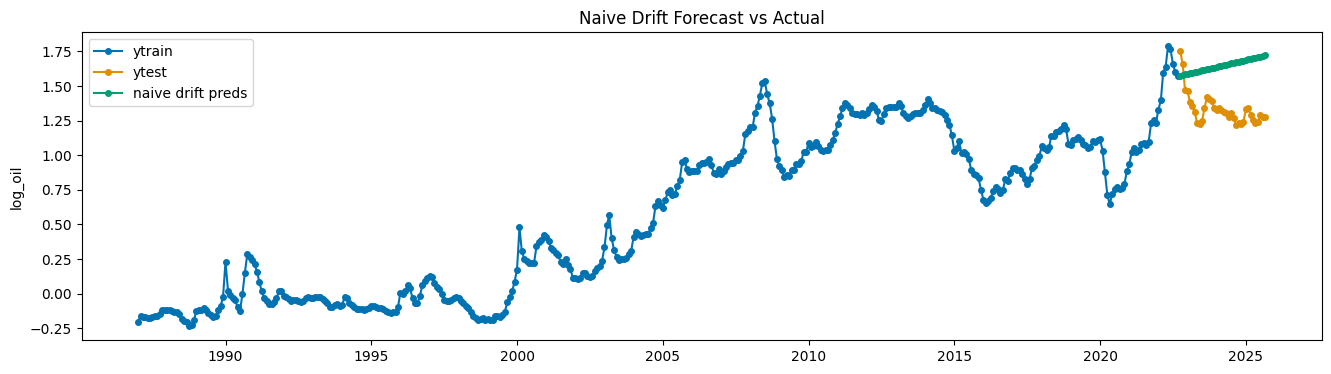

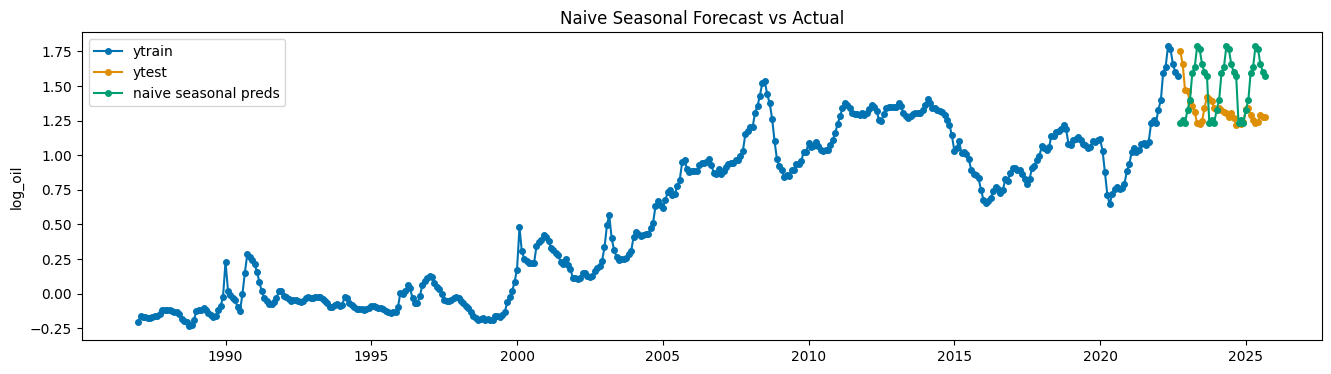

In [ ]:
### --- Baseline Models --- ###

# Naive forecast: last observed value
naive_last = NaiveForecaster(strategy='last')
naive_last.fit(y_train)
naive_last_preds = naive_last.predict(list(range(1, len(y_test)+1)))
plot_series(y_train, y_test, naive_last_preds, labels=['ytrain', 'ytest', 'naive last preds']);
plt.title("Naive Last Forecast vs Actual")
plt.show()

# Drift forecast
naive_drift = NaiveForecaster(strategy='drift')
naive_drift.fit(y_train)
naive_drift_preds = naive_drift.predict(list(range(1, len(y_test)+1)))
plot_series(y_train, y_test, naive_drift_preds, labels=['ytrain', 'ytest', 'naive drift preds']);
plt.title("Naive Drift Forecast vs Actual")
plt.show()

# Seasonal naive
naive_seasonal = NaiveForecaster(strategy='last',sp = 12)
naive_seasonal.fit(y_train)
naive_seasonal_preds = naive_seasonal.predict(list(range(1, len(y_test)+1)))
plot_series(y_train, y_test, naive_seasonal_preds, labels=['ytrain', 'ytest', 'naive seasonal preds']);
plt.title("Naive Seasonal Forecast vs Actual")
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-1380.461, Time=5.11 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1330.527, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1384.186, Time=0.78 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1377.836, Time=1.66 sec


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1329.698, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-1385.639, Time=0.83 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-1384.296, Time=2.38 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-1385.243, Time=3.11 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-1383.663, Time=1.57 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-1383.659, Time=1.75 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-1379.296, Time=1.21 sec


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-1381.640, Time=5.31 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-1386.287, Time=0.30 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-1384.903, Time=1.51 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-1385.018, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-1385.945, Time=1.68 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=-1384.293, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-1384.292, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=-1379.449, Time=0.37 sec


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,1)(0,0,0)[12]             : AIC=-1382.288, Time=0.53 sec

Best model:  ARIMA(1,1,0)(0,0,0)[12]          
Total fit time: 30.109 seconds


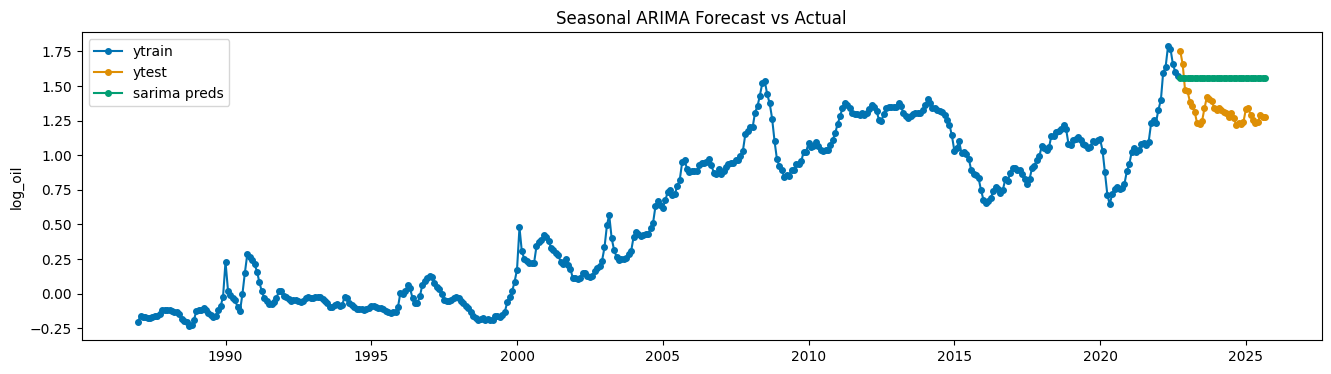

/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/adapters/_statsmodels.py:69: UserWarning: Warning: time series is not strictly positive, multiplicative components are omitted
  self._fit_forecaster(y, X)


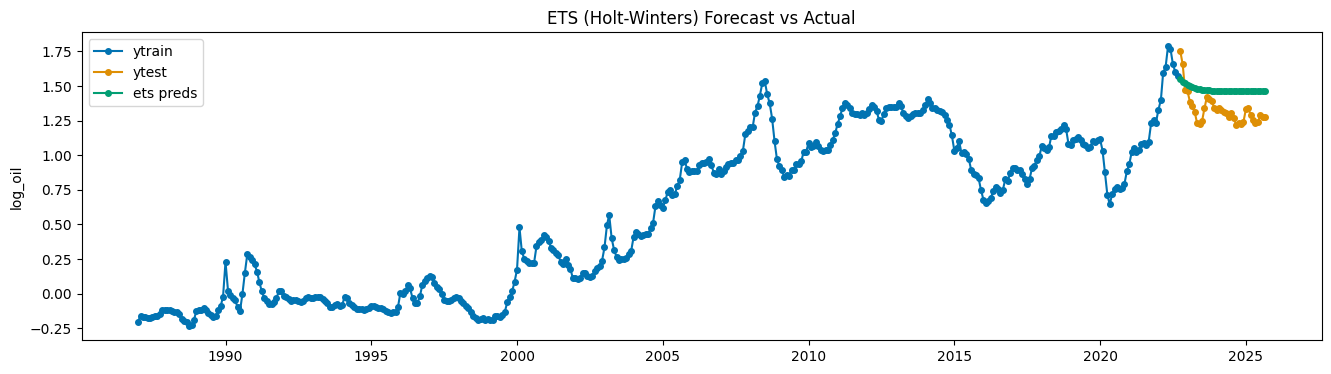

In [ ]:
### --- Classical Models --- ###

# AutoARIMA
sarima_model = AutoARIMA(sp = 12, trace=True)
sarima_model.fit(y_train)
sarima_preds = sarima_model.predict(list(range(1, len(y_test)+1)))
plot_series(y_train, y_test, sarima_preds, labels=['ytrain', 'ytest', 'sarima preds']);
plt.title("Seasonal ARIMA Forecast vs Actual")
plt.show()

# ETS (Exponential Smoothing)
ets_model = AutoETS(auto=True, sp=12)
ets_model.fit(y_train)
ets_preds = ets_model.predict(list(range(1, len(y_test)+1)))
plot_series(y_train, y_test, ets_preds, labels=['ytrain', 'ytest', 'ets preds']);
plt.title("ETS (Holt-Winters) Forecast vs Actual")
plt.show()

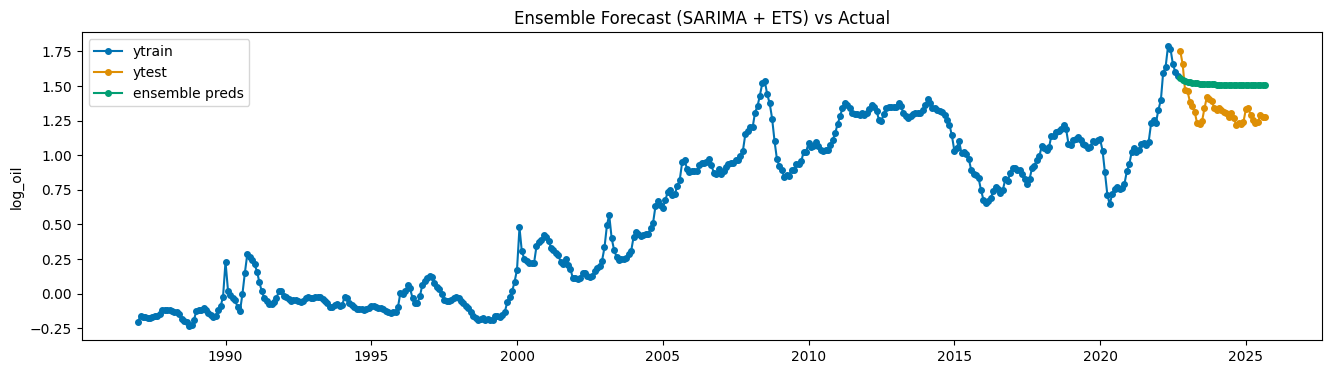

In [ ]:
### --- Ensemble Models --- ###

# Combine SARIMA and ETS forecasts
ensemble = EnsembleForecaster([
    ('sarima', sarima_model),
    ('ets_model', ets_model)
], n_jobs=-1)
ensemble.fit(y_train)
ensemble_preds = ensemble.predict(list(range(1, len(y_test)+1)))
plot_series(y_train, y_test, ensemble_preds,labels=['ytrain', 'ytest', 'ensemble preds']);
plt.title("Ensemble Forecast (SARIMA + ETS) vs Actual")
plt.show()

            Model      MAPE
0      Naive Last  0.197224
1     Naive Drift  0.256290
2  Naive Seasonal  0.205604
3          SARIMA  0.186237
4             ETS  0.124905
5        Ensemble  0.155571


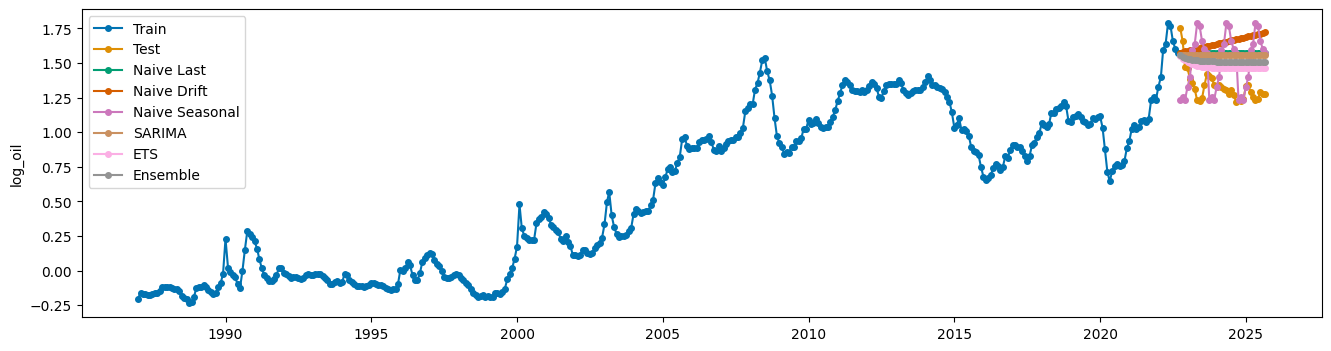

In [ ]:
### --- Model Evaluation --- ###

# Calculate mean absolute percentage error for each model
results = pd.DataFrame({
    'Model': ['Naive Last', 'Naive Drift', 'Naive Seasonal', 'SARIMA', 'ETS',  'Ensemble'],
    'MAPE': [
        mean_absolute_percentage_error(y_test, naive_last_preds),
        mean_absolute_percentage_error(y_test, naive_drift_preds),
        mean_absolute_percentage_error(y_test, naive_seasonal_preds),
        mean_absolute_percentage_error(y_test, sarima_preds),
        mean_absolute_percentage_error(y_test, ets_preds),
        mean_absolute_percentage_error(y_test, ensemble_preds)]
    })
print(results)

# Visual comparison
plot_series(y_train, y_test, naive_last_preds, naive_drift_preds, naive_seasonal_preds, sarima_preds, ets_preds, ensemble_preds,
            labels=['Train','Test','Naive Last', 'Naive Drift', 'Naive Seasonal','SARIMA','ETS','Ensemble'])
plt.show()


In [ ]:
### --- Forecast Residuals Using XGBoost and Exogenous Variables --- ###

# Generate in-sample ETS forecasts
fh_insample = ForecastingHorizon(y_train.index, is_relative=False)
ets_fitted = ets_model.predict(fh=fh_insample)

# Compute ETS residuals
residuals_train = (y_train - ets_fitted).dropna()

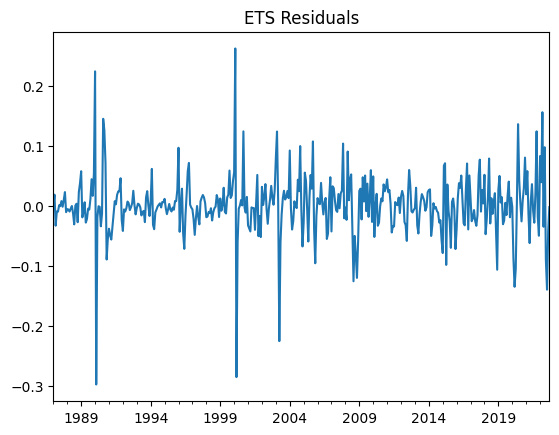

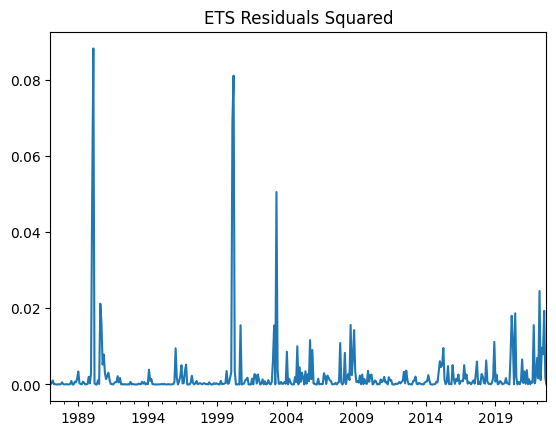

<Figure size 1000x400 with 0 Axes>

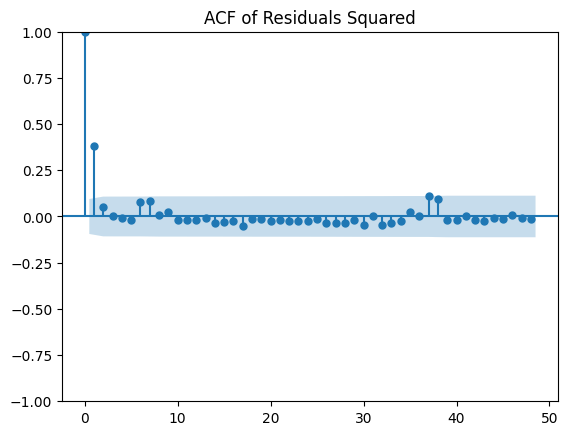

In [ ]:
### --- Check If Residuals are Forecastable --- ###

# Time series plot of residuals
residuals_train.plot(title='ETS Residuals')
plt.show()

residuals_squared = residuals_train**2
# Time series plot of squared residuals
residuals_squared.plot(title = 'ETS Residuals Squared')

# ACF of squared residuals
plt.figure(figsize=(10,4))
plot_acf(residuals_squared, lags=48)
plt.title("ACF of Residuals Squared")
plt.show()

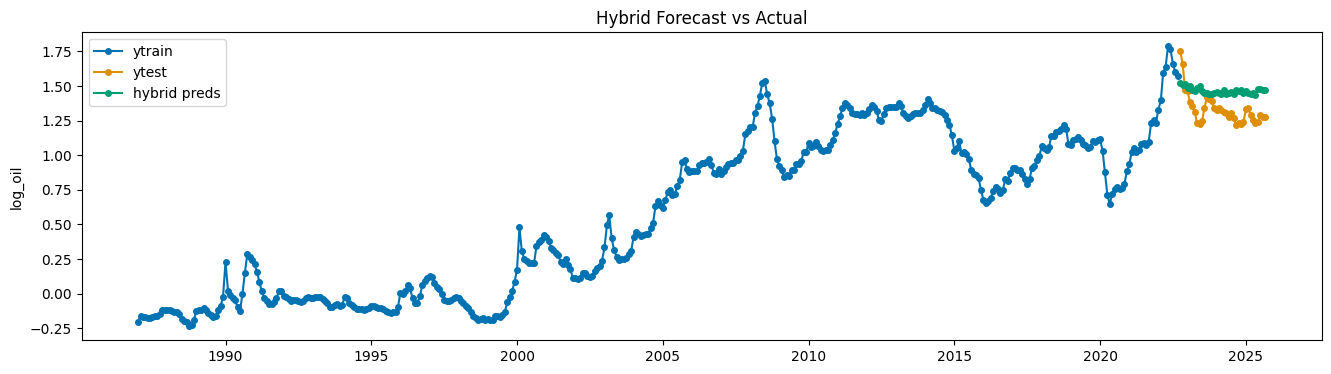

                  Model      MAPE
6  Hybrid ETS + XGBoost  0.119802
4                   ETS  0.124905
5              Ensemble  0.155571
3                SARIMA  0.186237
0            Naive Last  0.197224
2        Naive Seasonal  0.205604
1           Naive Drift  0.256290


In [ ]:
# Align X with residuals
X_resid_train = X_train.loc[residuals_train.index]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resid_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost model
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42)

# Fit XGBoost model on residuals
xgb.fit(X_train_scaled, residuals_train.values)

# Predict residuals of test data
residual_preds = xgb.predict(X_test_scaled)

# ETS + XGBoost final prediction
hybrid_preds = ets_preds + residual_preds

# Final accuracy comparing
results.loc[len(results)] = [
    "Hybrid ETS + XGBoost",
    mean_absolute_percentage_error(y_test, hybrid_preds)]

plot_series(y_train, y_test, hybrid_preds, labels=['ytrain', 'ytest', 'hybrid preds']);
plt.title("Hybrid Forecast vs Actual")
plt.show()

print(results.sort_values("MAPE"))
